In [1]:
%cd ..

/home/zaccharie/workspace/fastmri-reproducible-benchmark


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import glob

import h5py
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import compare_ssim as ssim
from tqdm import tqdm_notebook

from fourier import FFT2
from utils import crop_center, gen_mask
from wavelets import WaveletDecimated

from mri.numerics.gradient import GradAnalysis2
from modopt.opt.linear import Identity
from mri.numerics.linear import WaveletUD, Wavelet2
from mri.numerics.reconstruct import sparse_rec_condatvu, sparse_rec_fista
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx
from mri.numerics.gradient import GradAnalysis2


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.3.0     installed
numpy          : >=1.11.0  - required | 1.16.4    installed
matplotlib     : >=2.0.0   - required | 3.1.1     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.1.5   - requi

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
fourier_op = FFT2(np.array([1]))

# Loading input data

In [5]:
val_path = '../singlecoil_val/'
filenames = glob.glob(val_path + '*')

In [6]:
def from_file_to_mask_and_kspace(filename):
    h5_obj = h5py.File(filename)
    image = h5_obj['reconstruction_esc'][()]
    kspace = h5_obj['kspace'][()]
    return image, kspace

In [7]:
file_0 = filenames[5]
images,  kspaces = from_file_to_mask_and_kspace(file_0)

In [8]:
slice_selected = 10
kspace = kspaces[slice_selected]
image = images[slice_selected]

In [9]:
kspace.shape

(640, 368)

In [10]:
image.shape

(320, 320)

# Visualizing input data

<IPython.core.display.Javascript object>


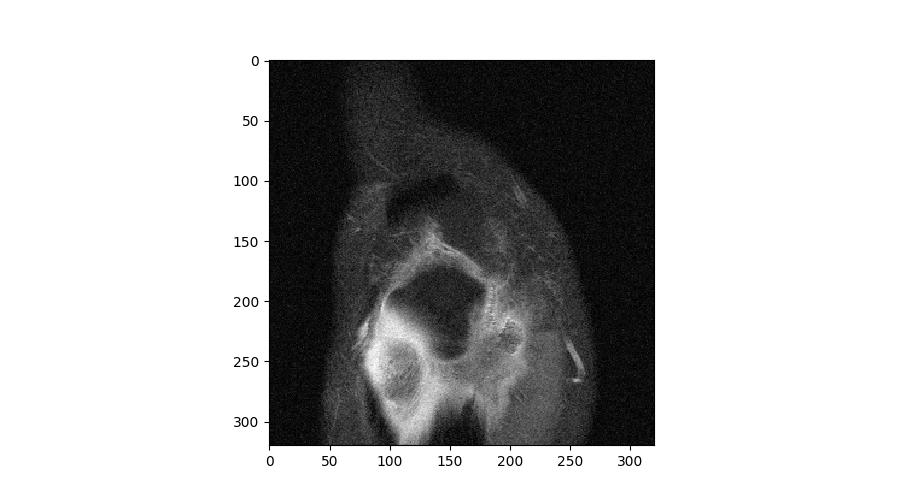

In [11]:
plt.figure()
plt.imshow(image)

<IPython.core.display.Javascript object>


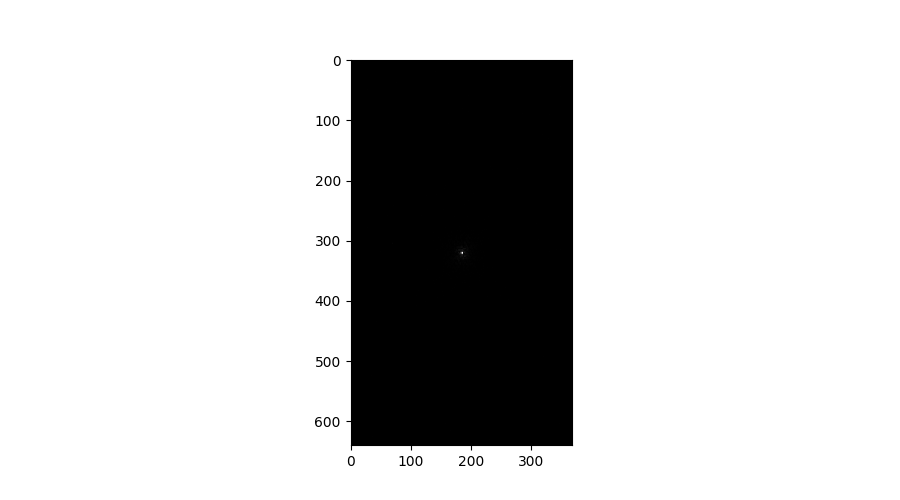

In [12]:
plt.figure()
plt.imshow(np.abs(kspace))

<IPython.core.display.Javascript object>


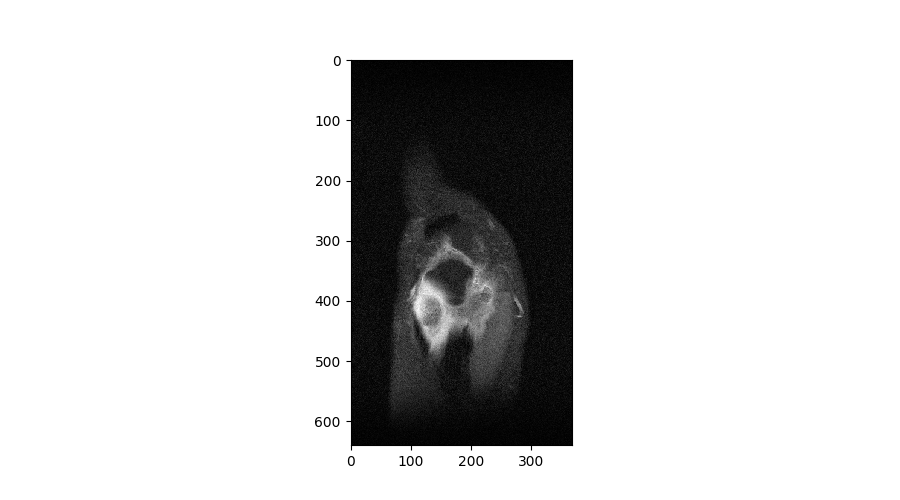

In [12]:
plt.figure()
plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(kspace))))

# Mask generation

In [13]:
accel_factor = 4
mask = gen_mask(kspace, accel_factor=accel_factor)
len(mask) / np.sum(mask)

4.043956043956044

# Create the operators

In [14]:
decimated = False

In [15]:
fourier_mask = np.repeat(mask.astype(np.float)[None, :], kspace.shape[0], axis=0)
fourier_op_masked = FFT2(mask=fourier_mask)
masked_kspace = kspace * fourier_mask

if decimated:
    nb_scales = 4
    wavelet_name = 'db4'
#     linear_op = Wavelet2(
#         nb_scale=nb_scales,
#         wavelet_name=wavelet_name,
#         padding='periodization',
#     )
    linear_op = WaveletDecimated(
        nb_scale=nb_scales,
        wavelet_name=wavelet_name,
        padding='periodization',
    )
    
    gradient_op = GradAnalysis2(
        data=masked_kspace,
        fourier_op=fourier_op_masked)

    # Define the proximity dual/primal operator
    prox_op = LinearCompositionProx(
        linear_op=linear_op,
        prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
    )
else:
    nb_scales = 4
    wavelet_id = 24
    linear_op = WaveletUD(
        nb_scale=nb_scales,
        wavelet_id=wavelet_id,
        set_norm=1.1,
    )

    gradient_op = GradAnalysis2(
        data=masked_kspace,
        fourier_op=fourier_op_masked)

    # Define the proximity dual/primal operator
    prox_op = SparseThreshold(linear_op, None, thresh_type="soft")
    cost_op = None

<IPython.core.display.Javascript object>


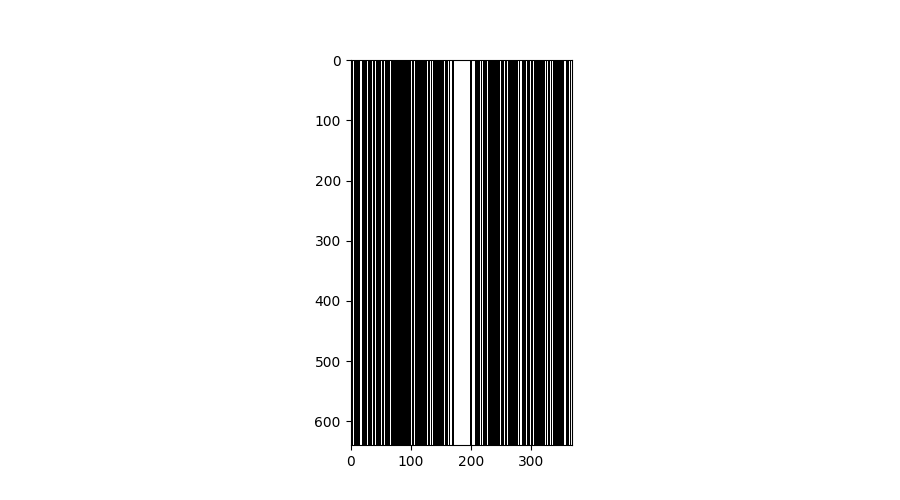

In [16]:
plt.figure()
plt.imshow(np.abs(fourier_mask))

In [24]:
mu = 1e-9

In [19]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(linear_op.op(x)))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op_masked.op(x) - masked_kspace)**2

In [20]:
def nrmse(x):
    im = crop_center(x, 320)
    return np.linalg.norm(np.abs(im) - image) / np.mean(image)

def psnr(x):
    im = crop_center(x, 320)
    mse = np.mean((np.abs(im) - image)**2)
    p = 10 * np.log10(np.max(image)**2 / mse)
#     import pdb; pdb.set_trace()
    return p

def ssim_crop(x):
    im = crop_center(x, 320)
    return ssim(image, np.abs(im))

In [21]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "psnr": {"metric": psnr, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "ssim": {"metric": ssim_crop, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

## Selecting best mu

In [34]:
n_exp = 10
mus = np.linspace(1e-8, 1e-7, n_exp)
mu_metrics = {}
psnrs = np.empty((n_exp, ))

In [35]:
mu_iter = 200

def psnr_for_mu(mu):
    cost_op = None
    if decimated:
        _, _, _, metrics = sparse_rec_fista(
            gradient_op=gradient_op,
            linear_op=Identity(),
            prox_op=prox_op,
            cost_op=cost_op,
            xi_restart=0.96,
            s_greedy=1.1,
            mu=mu,
            restart_strategy='greedy',
            pov='analysis',
            max_nb_of_iter=mu_iter,
            metrics=metrics_,
            metric_call_period=5,
            verbose=0,
        )
    else:
        _, _, _, metrics = sparse_rec_condatvu(
            gradient_op,
            linear_op,
            prox_op,
            cost_op,
            std_est_method=None,
            std_est=0.1,
            mu=mu,
            sigma=10,
            nb_of_reweights=0,
            max_nb_of_iter=mu_iter,
            metrics=metrics_,
            metric_call_period=5,
            verbose=0,
        )
    return metrics['psnr']['values'][-1]
import sys
sys.path.append('/home/zaccharie/workspace/fastmri-reproducible-benchmark/')
psnrs = np.array(Parallel(n_jobs=8)(delayed(psnr_for_mu)(mu) for mu in mus))

In [36]:
zero_filled_reco = np.abs(fourier_op_masked.adj_op(masked_kspace))
psnr(zero_filled_reco)

27.80804285484666

In [37]:
psnrs

array([27.80994271, 27.81132679, 27.81213678, 27.81238689, 27.81206024,
       27.81116303, 27.80967494, 27.80759201, 27.80496658, 27.80181357])

<IPython.core.display.Javascript object>


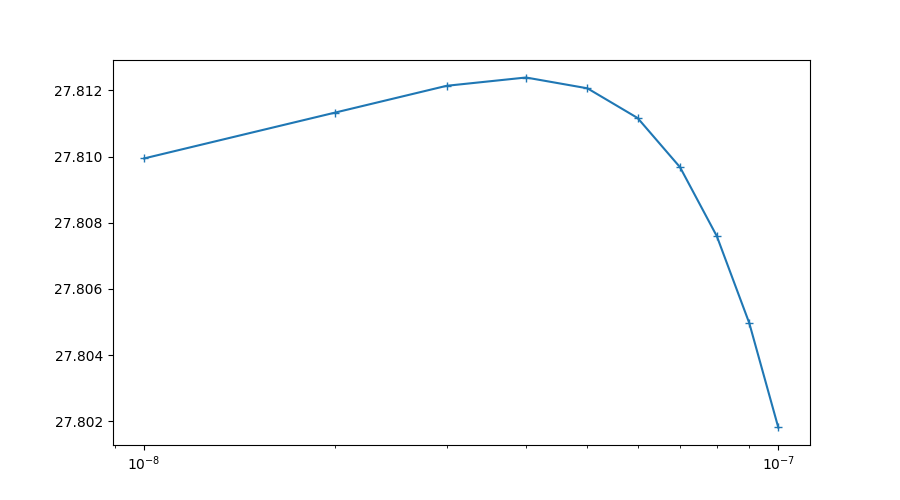

In [38]:
plt.figure()
plt.plot(mus, psnrs, marker='+')
plt.xscale("log")

In [33]:
# fig, axs = plt.subplots(1, 2)
# axs[0].plot(mus, mu_metrics['psnr'], marker='+')
# axs[0].xscale('log')
# axs[1].plot(mus, mu_metrics['nrmse'], marker='+')
# axs[1].xscale('log')

In [62]:
np.linalg.norm(image) / (image.shape[0] * image.shape[1])

1.2970480383955874e-07

In [39]:
mu = 4 * 1e-8

In [40]:
max_iter = 500

In [41]:
# Start the Condat reconstruction
cost_op = None
if decimated:
    x_final, _, _, metrics = sparse_rec_fista(
        gradient_op=gradient_op,
        linear_op=Identity(),
        prox_op=prox_op,
        cost_op=cost_op,
        xi_restart=0.96,
        s_greedy=1.1,
        mu=mu,
        restart_strategy='greedy',
        pov='analysis',
        max_nb_of_iter=max_iter,
        metrics=metrics_,
        metric_call_period=5,
        verbose=1,
    )
else:
    x_final, _, _, metrics = sparse_rec_condatvu(
        gradient_op,
        linear_op,
        prox_op,
        cost_op,
        std_est_method=None,
        std_est=0.1,
        mu=mu,
        sigma=10,
        nb_of_reweights=0,
        max_nb_of_iter=max_iter,
        metrics=metrics_,
        metric_call_period=1,
        verbose=1,
    )


   ____   U  ___ u  _   _    ____       _       _____      __     __    _   _
U /"___|   \/"_ \/ | \ |"|  |  _"\  U  /"\  u  |_ " _|     \ \   /"/uU |"|u| |
\| | u     | | | |<|  \| |>/| | | |  \/ _ \/     | |        \ \ / //  \| |\| |
 | |/__.-,_| |_| |U| |\  |uU| |_| |\ / ___ \    /| |\       /\ V /_,-. | |_| |
  \____|\_)-\___/  |_| \_|  |____/ u/_/   \_\  u |_|U      U  \_/-(_/ <<\___/
 _// \\      \\    ||   \\,-.|||_    \\    >>  _// \\_       //      (__) )(
(__)(__)    (__)   (_")  (_/(__)_)  (__)  (__)(__) (__)     (__)         (__)
    
 - mu:  4e-08
 - lipschitz constant:  1.1000000000000003
 - tau:  0.07905138333671825
 - sigma:  10
 - rho:  1.0
 - std:  0.1
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (640, 368)
 - wavelet:  <mri.reconstruct.linear.WaveletUD object at 0x7ff79f917780> - 4
 - max iterations:  500
 - number of reweights:  0
 - primal variable shape:  (640, 368)
 - dual variable shape:  (10, 640, 368)
----------------------------------------
Starting op

/home/zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
100% (500 of 500) |######################| Elapsed Time: 0:17:16 Time:  0:17:16


 - converged:  False
Done.
Execution time:  1811.710988  seconds
----------------------------------------


<IPython.core.display.Javascript object>


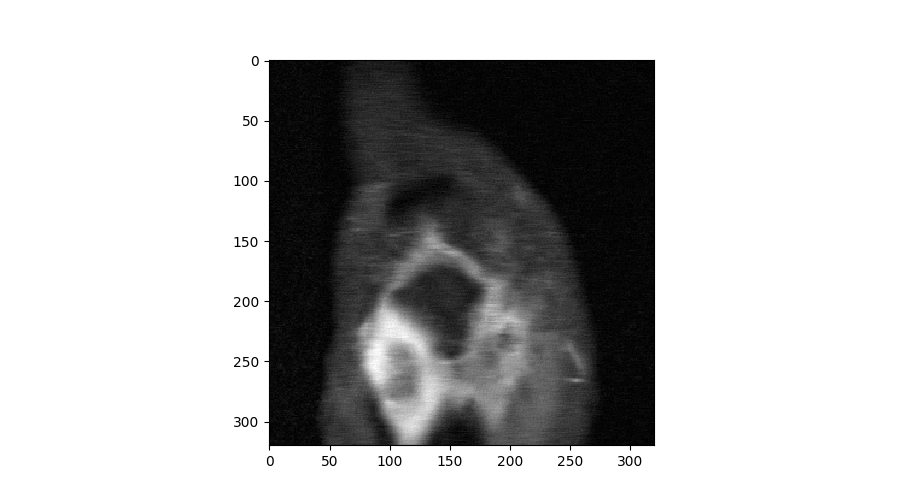

In [42]:
plt.figure()
plt.imshow(crop_center(np.abs(x_final), 320))

<IPython.core.display.Javascript object>


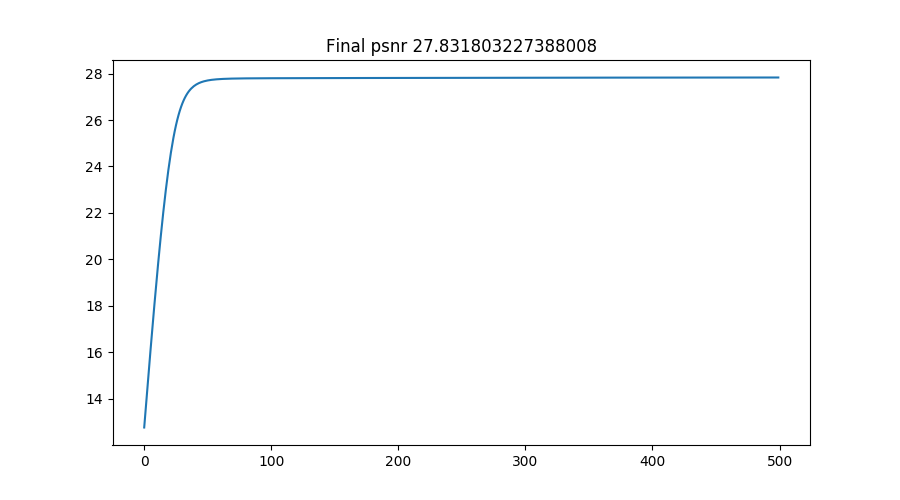

Text(0.5, 1.0, 'Final psnr 27.831803227388008')

In [43]:
plt.figure()
plt.plot(np.array(metrics['psnr']['values']))
plt.title('Final psnr {}'.format(metrics['psnr']['values'][-1]))

In [44]:
zero_filled_reco = np.abs(fourier_op_masked.adj_op(masked_kspace))
psnr(zero_filled_reco)

27.80804285484666